In [ ]:
pip install -q tf-nightly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
data_dir = '/content/drive/MyDrive/colab/clothes_classification/train/train_to_black'
data_dir = pathlib.Path(data_dir)

In [ ]:
''' import os
from PIL import Image

# 이미지 폴더 경로 지정
folder_path = '/content/drive/MyDrive/colab/clothes_classification/test/T-Shirt'

# 저장할 폴더 경로 지정 (기존 폴더와 동일하게 할 수 있으며, 다르게 할 경우 새 경로에 저장)
save_folder_path = '/content/drive/MyDrive/colab/clothes_classification/test/T-Shirt_to_black'

# 폴더 경로 내의 모든 파일 리스트
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for image_file in image_files:
    # 이미지 열기
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)

    # 흑백 변환
    bw_image = image.convert('L')

    # 흑백 이미지 저장 경로
    save_path = os.path.join(save_folder_path, 'bw_' + image_file)

    # 이미지 저장
    bw_image.save(save_path)

print("All images converted to black and white!") '''


All images converted to black and white!


In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1004


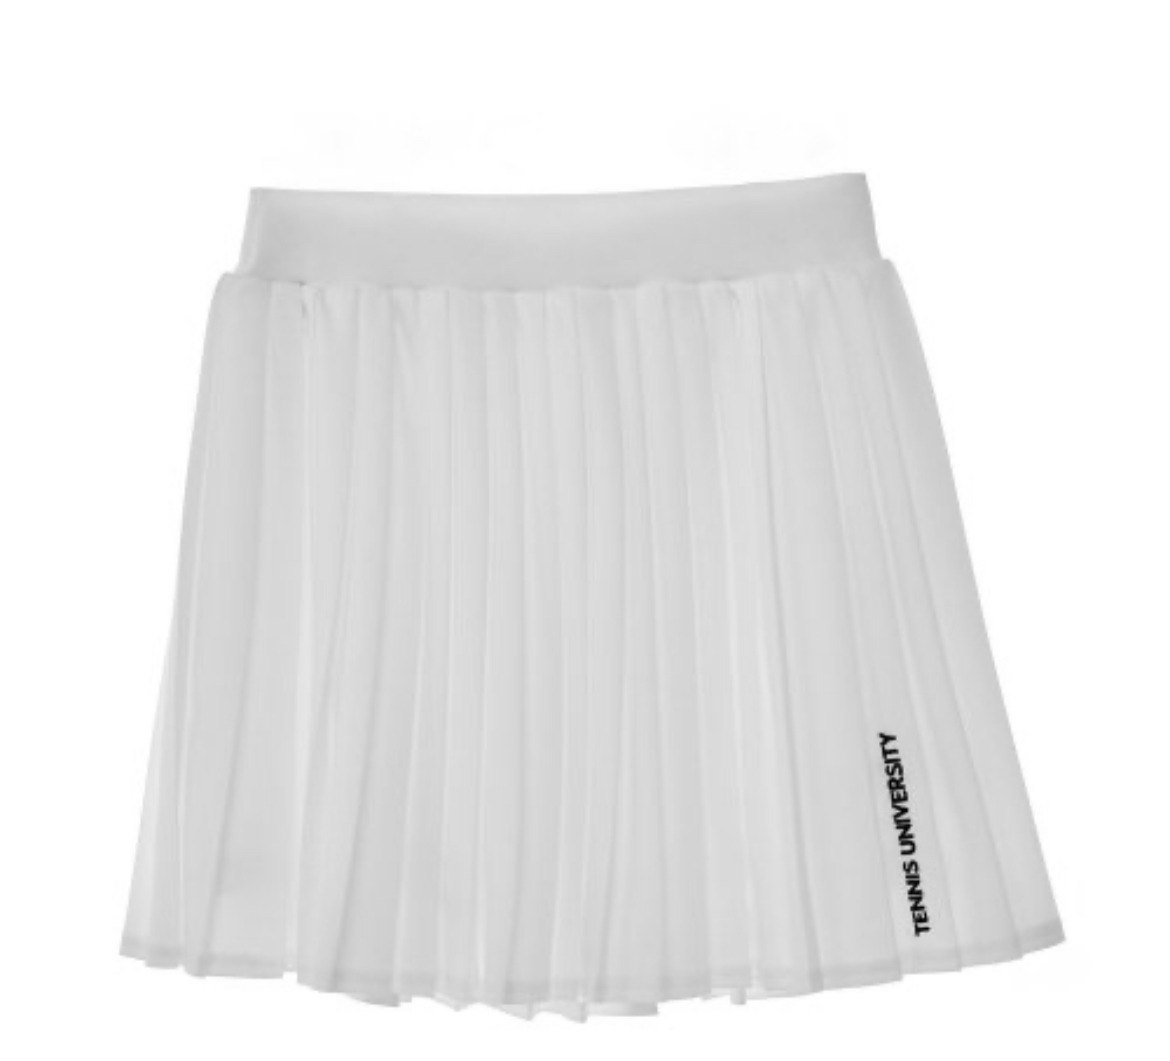

In [ ]:
clothes = list(data_dir.glob('Skirt/*'))
PIL.Image.open(str(clothes[20]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1022 files belonging to 9 classes.
Using 818 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1022 files belonging to 9 classes.
Using 204 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bag', 'Blouse', 'Jacket', 'Onepiece', 'Padding', 'Pants', 'Shirts', 'Skirt', 'T-Shirt']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.24826597 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# VGG16 모델 로드
base_model = VGG16(input_shape=(img_height, img_width, 3),
                   include_top=False, # 최상위 분류기 제외
                   weights='imagenet')

# 모델 학습 방지
for layer in base_model.layers:
    layer.trainable = False

# 사용자 정의 모델 정의
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout 레이어 추가
    Dense(9, activation='softmax') # num_classes는 분류하려는 클래스 수
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 17994057 (68.64 MB)
Trainable params: 3279369 (12.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 94s 3s/step - loss: 13.0120 - accuracy: 0.6137 - val_loss: 2.8518 - val_accuracy: 0.8627
Epoch 2/10
26/26 [==============================] - 4s 171ms/step - loss: 1.8491 - accuracy: 0.8973 - val_loss: 2.2026 - val_accuracy: 0.8873
Epoch 3/10
26/26 [==============================] - 4s 147ms/step - loss: 1.1075 - accuracy: 0.9254 - val_loss: 1.8158 - val_accuracy: 0.8725
Epoch 4/10
26/26 [==============================] - 4s 147ms/step - loss: 0.6502 - accuracy: 0.9425 - val_loss: 1.4633 - val_accuracy: 0.8971
Epoch 5/10
26/26 [==============================] - 5s 190ms/step - loss: 0.4717 - accuracy: 0.9499 - val_loss: 1.3949 - val_accuracy: 0.9020
Epoch 6/10
26/26 [==============================] - 4s 148ms/step - loss: 0.2794 - accuracy: 0.9560 - val_loss: 1.0751 - val_accuracy: 0.8873
Epoch 7/10
26/26 [==============================] - 4s 149ms/step - loss: 0.2668 - accuracy: 0.9548 - val_loss: 1.4371 - val_accuracy: 0.9069
Epoch 8

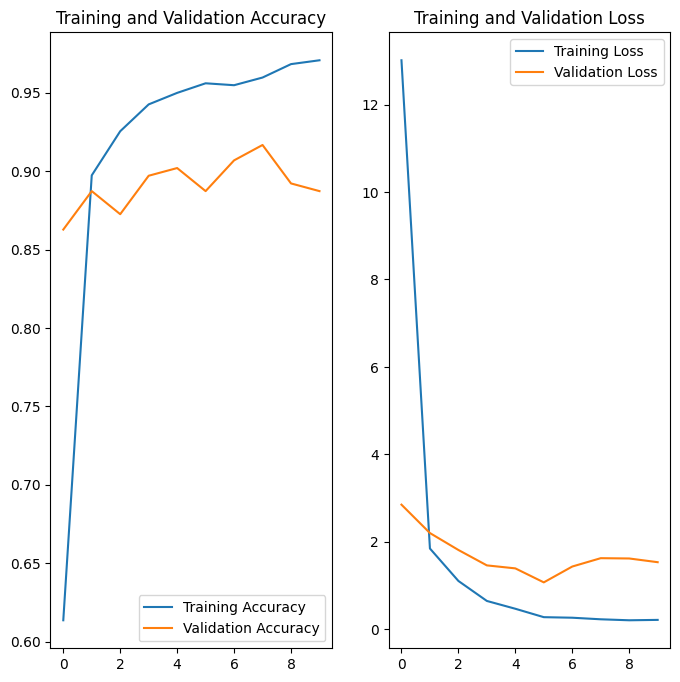

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 2s 80ms/step - loss: 1.5364 - accuracy: 0.8873


[1.536376953125, 0.8872548937797546]

In [ ]:
test_dir = '/content/drive/MyDrive/colab/clothes_classification/test/test_to_black'
test_dir = pathlib.Path(test_dir)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 103 files belonging to 9 classes.


In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 42s 407ms/step - loss: 2.9075 - accuracy: 0.7961


[2.9074666500091553, 0.7961165308952332]

In [ ]:
clothes_path = "/content/drive/MyDrive/colab/clothes_classification/test/Bag/bag00.png"

img = keras.preprocessing.image.load_img(
    clothes_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to Bag_to_black with a 25.26 percent confidence.


In [ ]:
import cv2

# 이미지 불러오기
image = cv2.imread('path_to_image.jpg')

# 이미지를 흑백으로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 변환된 이미지 저장
cv2.imwrite('path_to_save_gray_image.jpg', gray_image)